0.25


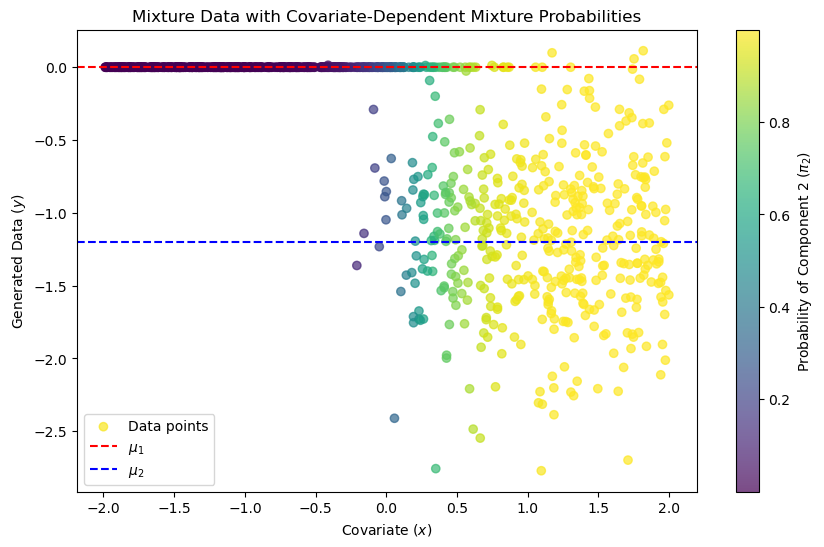

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
import random
import numpy as np
import torch

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


n_samples =1000
a, b = 5.0, -1.0  # Coefficients for logistic regression to control mixture probabilities
mu_1, sigma_1_sq = 0.0, 0.2
mu_2, sigma_2_sq = -1.20,  0.5


print(sigma_2_sq   **2 )

sebetahat= np.random.uniform( 0.1, 0.5, n_samples)
# Covariates
x = np.random.uniform(-2, 2, n_samples)

# Mixture probabilities
pi_2 = 1 / (1 + np.exp(-(a * x + b)))  # Sigmoid function for covariate-dependent pi_2
pi_1 = 1 - pi_2  # Ensure pi_1 + pi_2 = 1

# Generate data
y = np.zeros(n_samples)
betahat = np.zeros(n_samples)
c = np.zeros(n_samples, dtype=int)  # Ensure c is an integer array
for i in range(n_samples):
    # Use .item() to extract the scalar from np.random.choice
    c[i] = np.random.choice([0, 1], p=[pi_1[i], pi_2[i]])
    if c[i] == 0:
        y[i] = 0
        betahat[i]= y[i]+ np.random.normal(0, sebetahat[i] )
    else:
        y[i] = np.random.normal(mu_2,  sigma_2_sq   )
        betahat[i]= y[i]+ np.random.normal(0,   sebetahat[i] )


# Visualize the data
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=pi_2, cmap='viridis', label='Data points', alpha=0.7)
plt.colorbar(label='Probability of Component 2 ($\pi_2$)')
plt.axhline(mu_1, color='red', linestyle='--', label='$\mu_1$')
plt.axhline(mu_2, color='blue', linestyle='--', label='$\mu_2$')
plt.xlabel('Covariate ($x$)')
plt.ylabel('Generated Data ($y$)')
plt.title('Mixture Data with Covariate-Dependent Mixture Probabilities')
plt.legend()
plt.show()


In [26]:
np.var(y)

0.45299958773583665

In [27]:
np.var(betahat)

0.5447579381462985

In [28]:
0.2**2+0.5**2

0.29000000000000004

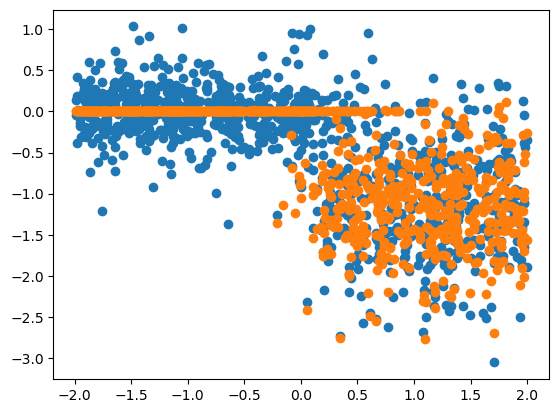

In [29]:

plt.scatter(x,betahat)
 
plt.scatter(x,y)

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the MDN model
class MDN(nn.Module):
    def __init__(self, input_dim):
        super(MDN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)  # Output: logit for pi_2
        )
        self.mu_1 = 0.0  # Fixed mean for component 1
        self.sigma_1_sq = 0.0  # Fixed variance for component 1
        self.mu_2 = nn.Parameter(torch.tensor(0.0))  # Learnable mean for component 2

    def forward(self, x):
        logit_pi2 = self.fc(x).squeeze()
        pi_2 = torch.sigmoid(logit_pi2)
        pi_1 = 1 - pi_2
        return pi_1, pi_2, self.mu_2


# Loss function: Negative Log Likelihood
def mdn_loss(pi_1, pi_2, mu_2, sigma_2_sq, targets, sd_noise):
    mu_1 = torch.tensor(0.0)
    sigma_1_sq_total = sd_noise**2
    sigma_2_sq_total = sigma_2_sq + sd_noise**2

    p1 = (1 / torch.sqrt(2 * torch.pi * sigma_1_sq_total)) * torch.exp(-0.5 * ((targets - mu_1) ** 2) / sigma_1_sq_total)
    p2 = (1 / torch.sqrt(2 * torch.pi * sigma_2_sq_total)) * torch.exp(-0.5 * ((targets - mu_2) ** 2) / sigma_2_sq_total)

    mixture_pdf = pi_1 * p1 + pi_2 * p2
    return -torch.mean(torch.log(mixture_pdf + 1e-8))


# Compute responsibilities (gamma values) for component 2
def compute_responsibilities(pi_1, pi_2,   mu_2, sigma_2_sq, targets, sd_noise):
    sigma_1_sq_total =0 + sd_noise**2
    sigma_2_sq_total = sigma_2_sq + sd_noise**2

    p1 = (1 / torch.sqrt(2 * torch.pi * sigma_1_sq_total)) * torch.exp(-0.5 * ((targets ) ** 2) / sigma_1_sq_total)
    p2 = (1 / torch.sqrt(2 * torch.pi * sigma_2_sq_total)) * torch.exp(-0.5 * ((targets - mu_2) ** 2) / sigma_2_sq_total)

    return (pi_2 * p2) / (pi_1 * p1 + pi_2 * p2)
  
# Perform the M-step to update sigma_2^2
def m_step_sigma2(gamma_2, mu_2, targets, sd_noise):
    residuals_sq = (targets - mu_2) ** 2
    sigma_0_sq = sd_noise**2
    numerator = torch.sum(( gamma_2 )* (residuals_sq - sigma_0_sq))
    denominator = torch.sum(( gamma_2 ))
    return torch.clamp(numerator / denominator, min=1e-6)


# Generate training data
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(betahat, dtype=torch.float32)
obs_sd_noise = torch.tensor(sebetahat, dtype=torch.float32)

# Initialize model and optimizer
model = MDN(input_dim=1)
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.01)

# Training loop
n_epochs = 1000
sigma_2_sqe = torch.tensor(1, requires_grad=False)

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    pi_1, pi_2, mu_2e = model(x_tensor)

    gamma_2 = compute_responsibilities(
        pi_1=pi_1, pi_2=pi_2,
       
        mu_2=mu_2e, 
        sigma_2_sq=sigma_2_sqe,
        targets=y_tensor,
        sd_noise=obs_sd_noise
    ) 
    with torch.no_grad():
        sigma_2_sqe = m_step_sigma2( gamma_2, mu_2e, y_tensor, obs_sd_noise)

    loss = mdn_loss(pi_1, pi_2, mu_2e, sigma_2_sqe, y_tensor, obs_sd_noise)

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, Sigma_2^2: {sigma_2_sqe.item()}")

# Evaluation



Epoch 0, Loss: 1.159550428390503, Sigma_2^2: 1.3104465007781982
Epoch 100, Loss: 0.573453962802887, Sigma_2^2: 0.34505370259284973
Epoch 200, Loss: 0.5569034218788147, Sigma_2^2: 0.2905484437942505
Epoch 300, Loss: 0.5562016367912292, Sigma_2^2: 0.28733065724372864
Epoch 400, Loss: 0.5556877255439758, Sigma_2^2: 0.2855231463909149
Epoch 500, Loss: 0.5551790595054626, Sigma_2^2: 0.2847030758857727
Epoch 600, Loss: 0.5544813275337219, Sigma_2^2: 0.2841084599494934
Epoch 700, Loss: 0.5535573959350586, Sigma_2^2: 0.2837343215942383
Epoch 800, Loss: 0.5529693365097046, Sigma_2^2: 0.2836405336856842
Epoch 900, Loss: 0.5526161789894104, Sigma_2^2: 0.28271833062171936


In [31]:
model.eval()
with torch.no_grad():
    pi_1, pi_2, mu_2e = model(x_tensor)

pi_np = pi_2.detach().numpy()
mu_2e= mu_2e.detach().numpy()
sigma_prior = np.sqrt(sigma_2_sqe.detach().numpy())/2


post_mean = np.zeros_like(betahat)
post_var = np.zeros_like(betahat)
import os
import sys
import matplotlib.pyplot as plt
sys.path.append(r"C:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
from posterior_computation import *

for i in range(len(betahat)):
        post_mean[i], post_var[i] = posterior_point_mass_normal(
            betahat=betahat[i],
            sebetahat=sebetahat[i],
            pi=( 1-pi_np[i]),  # Scalar pi for each observation
            mu0=0,  # Fixed mean for the point mass
            mu1=mu_2e,  # Global parameter
            sigma_0=sigma_prior  # Global parameter
            )
post_mean2= post_var+ post_mean**2 

In [32]:
posterior_point_mass_normal(
            betahat=betahat[i],
            sebetahat=sebetahat[i],
            pi=( pi_np[i]),  # Scalar pi for each observation
            mu0=0,  # Fixed mean for the point mass
            mu1=mu_2e,  # Global parameter
            sigma_0=sigma_prior  # Global parameter
            )

(-0.9454773524360212, 0.05463236023332984)

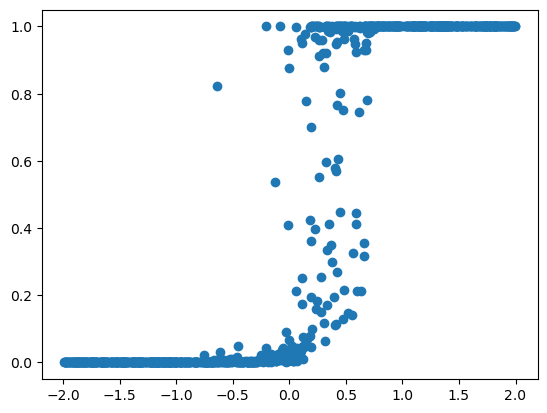

In [33]:
plt.scatter(x,gamma_2.detach().numpy() )

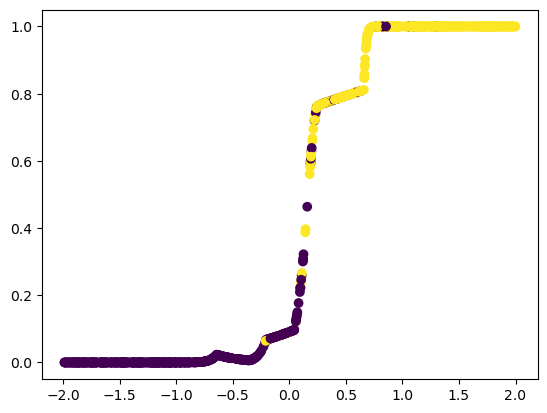

In [34]:
plt.scatter(x,pi_2.detach().numpy(), c=c )

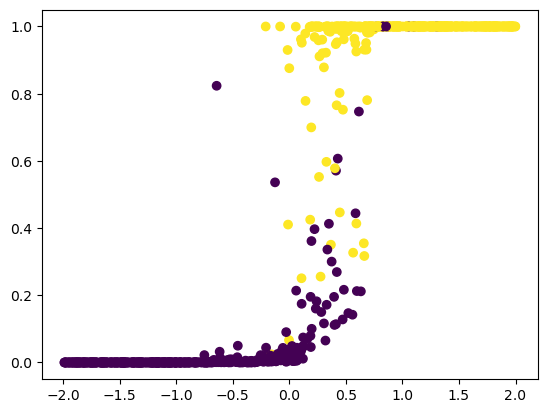

In [35]:
plt.scatter(x,gamma_2.detach().numpy(), c=c )

In [36]:
gamma_2.detach().numpy() 

array([1.00000000e+00, 2.50566119e-14, 6.43029898e-06, 7.83075672e-03,
       7.80762315e-01, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       3.50290321e-07, 8.65113970e-12, 1.00000000e+00, 9.96671855e-01,
       1.36584248e-02, 9.92627203e-01, 1.00000000e+00, 8.18236172e-03,
       5.24820061e-05, 5.95198129e-04, 1.20088635e-02, 8.39331042e-05,
       1.17321815e-02, 1.00000000e+00, 4.27692584e-07, 8.71329801e-04,
       6.78643165e-03, 1.98261607e-02, 1.75777313e-08, 1.68867223e-03,
       4.07394487e-03, 1.92813445e-06, 3.05319228e-03, 2.53940970e-02,
       9.85932767e-01, 8.17301583e-15, 7.93652833e-02, 6.16111491e-13,
       1.00000000e+00, 1.73314291e-07, 1.00000000e+00, 9.99975801e-01,
       1.06658911e-10, 4.91047740e-06, 9.99997735e-01, 8.04497961e-12,
       9.99959528e-01, 1.01460804e-15, 5.36534353e-04, 5.12047518e-05,
       1.00000000e+00, 6.04535990e-06, 5.71817742e-04, 1.00000000e+00,
       9.58770931e-01, 1.00000000e+00, 1.28784043e-15, 6.06773376e-01,
      

In [37]:
tt= (betahat-mu_2)**2

print(sum(( gamma_2.detach().numpy()* (tt))))
print(sum(gamma_2.detach().numpy()* (sebetahat**2)))
sum(gamma_2.detach().numpy())

175.33313068628038
47.8018838142801


443.2765375440665

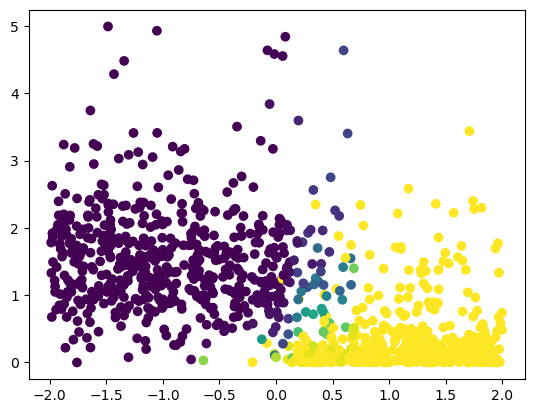

In [38]:
plt.scatter(x,tt,c=gamma_2.detach().numpy() )


In [39]:
sigma_2_sq**2

0.25

In [40]:
sigma_2_sqe.detach().numpy()

array(0.28325966, dtype=float32)

<function matplotlib.pyplot.ylabel(ylabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['bottom', 'center', 'top'] | None" = None, **kwargs) -> 'Text'>

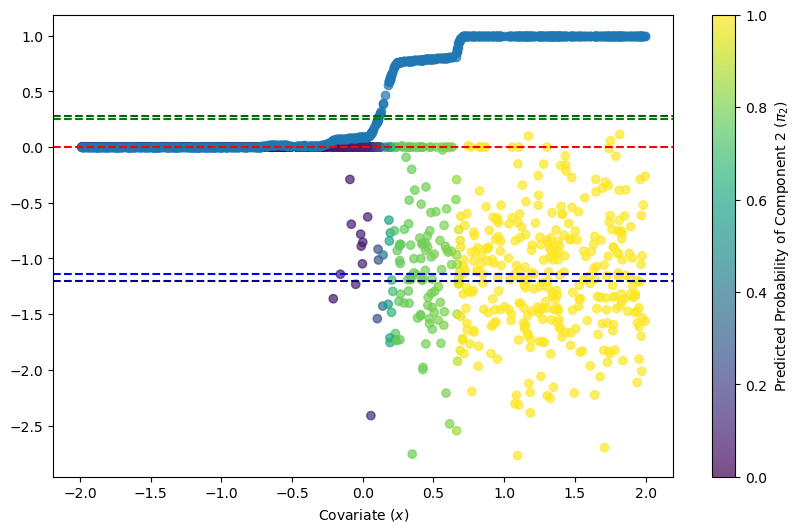

In [41]:
# Visualize predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=pi_2.numpy(), cmap='viridis', alpha=0.7, label='Data points')
plt.scatter(x, pi_2,  alpha=0.7 )
plt.colorbar(label='Predicted Probability of Component 2 ($\pi_2$)')
plt.axhline(0.0, color='red', linestyle='--', label='Fixed $\mu_1$')
plt.axhline(mu_2e , color='blue', linestyle='--', label='Predicted $\mu_2$')

plt.axhline(mu_2, color='darkblue', linestyle='--', label='Predicted $\mu_2$')
plt.axhline(sigma_2_sq   **2 , color='green', linestyle='--', label='Predicted $\mu_2$')

plt.axhline( sigma_2_sqe.detach().numpy(), color='darkgreen', linestyle='--', label='Predicted $\mu_2$')
plt.xlabel('Covariate ($x$)')
plt.ylabel


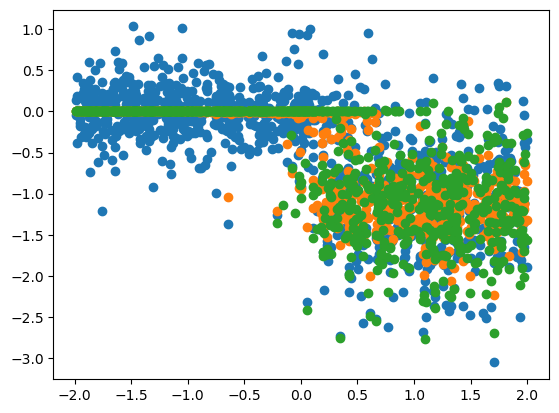

In [42]:
plt.scatter(x,betahat
            )
plt.scatter(x, post_mean)
plt.scatter(x, y)

(array([527.,  14.,   7.,   8.,   6.,   5.,   2.,   5.,   4., 422.]),
 array([4.04175509e-16, 1.00000001e-01, 2.00000003e-01, 3.00000012e-01,
        4.00000006e-01, 5.00000000e-01, 6.00000024e-01, 6.99999988e-01,
        8.00000012e-01, 8.99999976e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

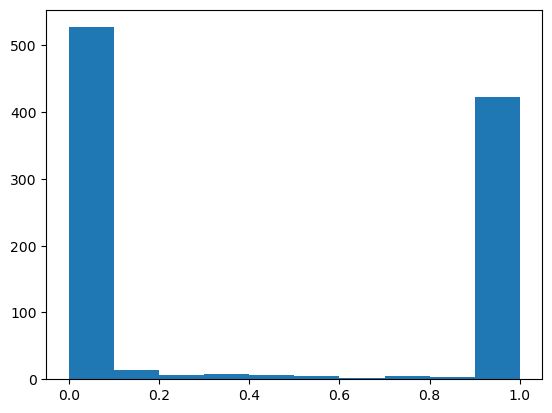

In [43]:
plt.hist(gamma_2.detach().numpy() )

In [44]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(r"D:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
from empirical_mdn import *
from covaraite_moderated_generalized_binary import *

In [45]:
res = cgb_posterior_means(x, betahat, sebetahat)

Epoch 0, Loss: 1.1917279958724976, Sigma_2^2: 1.2200182676315308


In [46]:
mu_2

-1.2

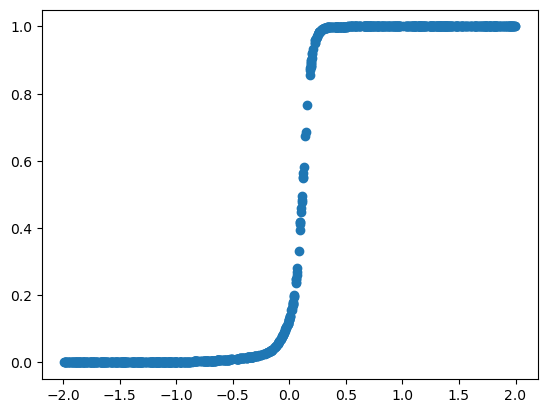

In [47]:
plt.scatter(x, res.pi)

<function matplotlib.pyplot.ylabel(ylabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['bottom', 'center', 'top'] | None" = None, **kwargs) -> 'Text'>

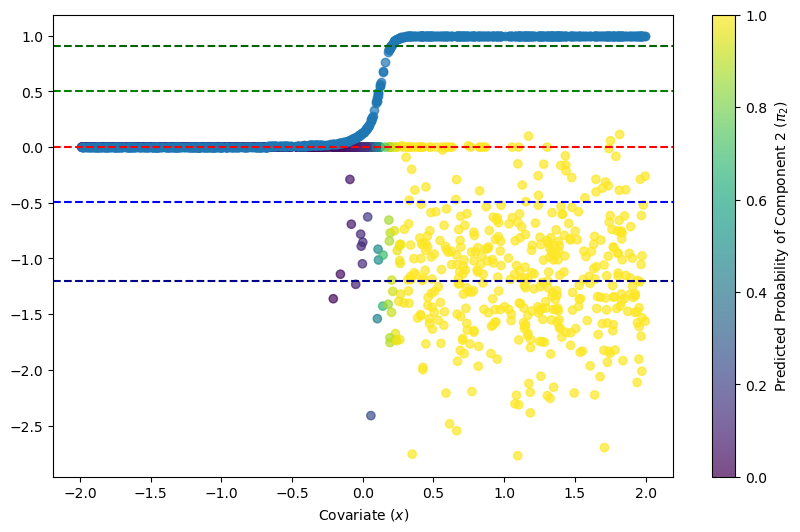

In [48]:
# Visualize predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c= res.pi, cmap='viridis', alpha=0.7, label='Data points')
plt.scatter(x,  res.pi,  alpha=0.7 )
plt.colorbar(label='Predicted Probability of Component 2 ($\pi_2$)')
plt.axhline(0.0, color='red', linestyle='--', label='Fixed $\mu_1$')
plt.axhline(res.mu_1 , color='blue', linestyle='--', label='Predicted $\mu_2$')

plt.axhline(mu_2, color='darkblue', linestyle='--', label='Predicted $\mu_2$')
plt.axhline(sigma_2_sq    , color='green', linestyle='--', label='Predicted $\mu_2$')

plt.axhline( np.sqrt( res.sigma_0 ), color='darkgreen', linestyle='--', label='Predicted $\mu_2$')
plt.xlabel('Covariate ($x$)')
plt.ylabel


In [49]:
res.mu_1

array(-0.49306396, dtype=float32)

In [50]:
mu_2

-1.2

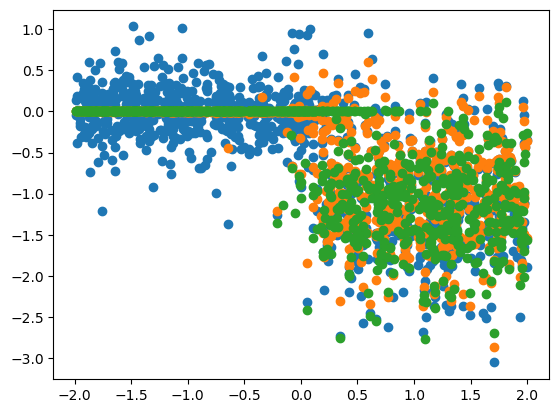

In [51]:
plt.scatter(x,betahat
            )
plt.scatter(x, res.post_mean)
plt.scatter(x, y)

In [52]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(r"D:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
from empirical_mdn import *
from hard_covaraite_moderated_generalized_binary import *

In [53]:
res = cgb_hard_posterior_means(x, betahat, sebetahat)

Epoch 0, Loss: 3.910057544708252 


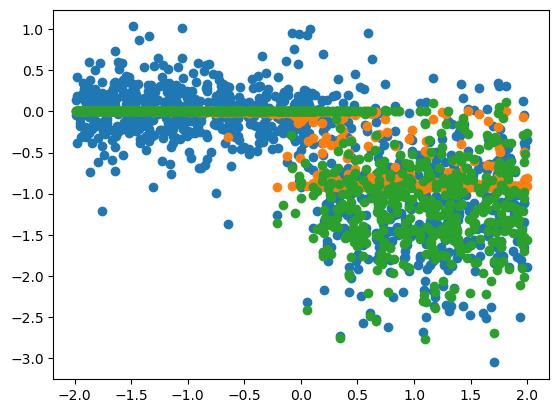

In [54]:
plt.scatter(x,betahat
            )
plt.scatter(x, res.post_mean)
plt.scatter(x, y)